<a href="https://colab.research.google.com/github/YanSym/Data-Science-Projects/blob/master/NLP_Analise_Sentimentos_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP: Natural Language Processing
### Analise de sentimentos

<img src="https://miro.medium.com/max/960/0*xLRsbQ02J7sQpNNy" width=600 height=350/>

### Imports

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from numpy import array
from numpy import asarray
from numpy import zeros
import re
import nltk
import tensorflow_hub as hub
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dropout, Dense, Embedding
from tensorflow.keras.layers import Flatten, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, SpatialDropout1D
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

!pip install transformers
!pip install ktrain

import ktrain
from ktrain import text
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

#import kerastuner as kt
#from kerastuner.tuners import BayesianOptimization
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Métodos

In [2]:
TAG_RE = re.compile(r'<[^>]+>')
list_stop_words = set(stopwords.words('english'))
    
# plot resultados
def plot_results(history):
    # acuracia
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()


# pre-processamento
def preprocess_text(sen):
    
    # Removing html tags
    sentence = TAG_RE.sub('', sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # lowercase
    sentence = sentence.lower()
    
    # remove stopwords
    #sentence = [w for w in sentence if w not in list_stop_words]

    return sentence

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Dataset

In [4]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

df_train = pd.DataFrame({'review':train_examples, 'sentiment':train_labels})
df_test = pd.DataFrame({'review':test_examples, 'sentiment':test_labels})

movie_reviews = pd.concat([df_train, df_test]).reset_index(drop=True)

movie_reviews['review'] = movie_reviews['review'].str.decode("utf-8")

print (movie_reviews.isnull().values.any())
print (movie_reviews.shape)

# amostra
movie_reviews, _ = train_test_split(movie_reviews, train_size=0.1, random_state=42, stratify=movie_reviews['sentiment'])
print (movie_reviews.shape)
movie_reviews.head()

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: imdb_reviews/plain_text/1.0.0
INFO:absl:Load dataset info from /tmp/tmpd7lsqac6tfds
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

INFO:absl:Downloading http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz into /root/tensorflow_datasets/downloads/ai.stanfor.edu_amaas_sentime_aclImdb_v1PaujRp-TxjBWz59jHXsMDm5WiexbxzaFQkEnXc3Tvo8.tar.gz.tmp.1fbcbc66ff484dc0b6a69db79143e30f...
INFO:absl:Generating split train


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZXXI3I/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZXXI3I/imdb_reviews-train.tfrecord. Shard lengths: [25000]
INFO:absl:Generating split test


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZXXI3I/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZXXI3I/imdb_reviews-test.tfrecord. Shard lengths: [25000]
INFO:absl:Generating split unsupervised


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZXXI3I/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZXXI3I/imdb_reviews-unsupervised.tfrecord. Shard lengths: [50000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split ['train', 'test'], from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
False
(50000, 2)
(5000, 2)


,review,sentiment
41986,I was expecting a lot from Mr.Amitabh Bachan's...,0
33935,"Well, it has to be said that Monster Man is a ...",1
46975,Even though I have great interest in Biblical ...,0
16402,The world is made up two different types of mo...,1
39790,Background info - The movies Octopussy & Never...,1


### Analises

1    2500
0    2500
Name: sentiment, dtype: int64


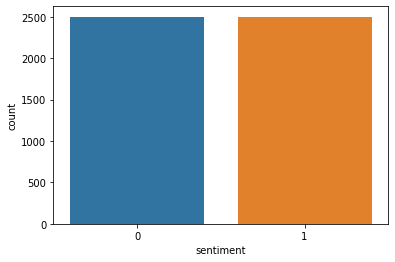

In [5]:
print (movie_reviews['sentiment'].value_counts(dropna=False))
sns.countplot(x='sentiment', data=movie_reviews)

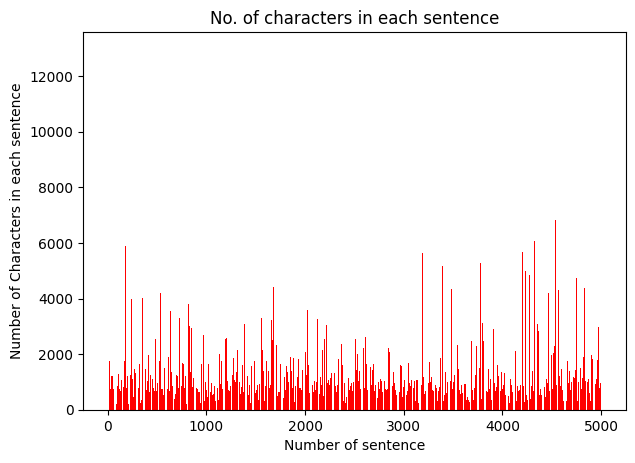

In [6]:
sentences = [len(sent) for sent in movie_reviews['review']]
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1, len(sentences)+1), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

### Pre-processamento

In [7]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))
    
y = movie_reviews['sentiment']

### Separa dados em treino e teste

In [8]:
# treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val_tmp, X_test_tmp, y_val_tmp, y_test_tmp = train_test_split(X_test, y_test, test_size=0.20, random_state=42)

### Tokenizer

In [9]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val_tmp = tokenizer.texts_to_sequences(X_val_tmp)
X_test_tmp = tokenizer.texts_to_sequences(X_test_tmp)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val_tmp = pad_sequences(X_val_tmp, padding='post', maxlen=maxlen)
X_test_tmp = pad_sequences(X_test_tmp, padding='post', maxlen=maxlen)

## Modelos com Bag of Words

### Bag of Words

<img src="https://i.ibb.co/j5Dj80T/bad.png" width=400 height=200/>

In [10]:
X_train_str = []
for lista in X_train:
    lista = ' '.join([str(x) for x in lista])
    X_train_str.append(lista)
    
X_test_str = []
for lista in X_test:
    lista = ' '.join([str(x) for x in lista])
    X_test_str.append(lista)
    
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')

#transform train
Count_data_train = CountVec.fit_transform(X_train_str)
 
#create dataframe
df_train_str=pd.DataFrame(Count_data_train.toarray(), columns=CountVec.get_feature_names())


#transform test
Count_data_test = CountVec.transform(X_test_str)
 
#create dataframe
df_test_str=pd.DataFrame(Count_data_test.toarray(), columns=CountVec.get_feature_names())

### BoW (Bag of Words) + Logistic Regression

In [11]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

# score medio
y_pred = classifier.predict_proba(df_train_str)[:, 1]

Train Accuracy: 0.9988
Test Accuracy: 0.799


### Score test

In [12]:
def score_list(list_instances):
    
    list_scores = []
    
    for text in list_instances:
        instance = tokenizer.texts_to_sequences([text])
        instance = pad_sequences(instance, padding='post', maxlen=maxlen)   
        instance = ' '.join([str(x) for x in instance])
        
        #transform test
        instance = CountVec.transform([instance])

        #create dataframe
        instance=pd.DataFrame(instance.toarray(), columns=CountVec.get_feature_names())

        score = classifier.predict_proba(instance)[:, 1][0]
        print (score)
        
        if (score >= 0.5):
            flag = 'Positivo'
        else:
            flag = 'Negativo'
            
        list_scores.append([text, score, flag])
        
    df = pd.DataFrame(list_scores, columns=['text', 'score', 'rating'])
    display(df)
        
        
list_instances = ['The movie was amazing, I loved it, very good',
                  'I hate this movie, it is very bad and terrible']
# score list
score_list(list_instances)

0.9393853698669685
0.09259102304322094


,text,score,rating
0,"The movie was amazing, I loved it, very good",0.939385,Positivo
1,"I hate this movie, it is very bad and terrible",0.092591,Negativo


### BoW (Bag of Words) + Naive Bayes

In [13]:
classifier = GaussianNB()
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8908
Test Accuracy: 0.688


### BoW (Bag of Words) + Random Forest

In [14]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8288
Test Accuracy: 0.789


## Modelos com tf-idf

<img src="https://miro.medium.com/max/1000/1*KZrjbKHcsWt-zzUj2oRk3w.jpeg" width=400 height=200/>

<img src="https://i.ytimg.com/vi/vZAXpvHhQow/maxresdefault.jpg" width=600 height=290/>

In [15]:
X_train_str = []
for lista in X_train:
    lista = ' '.join([str(x) for x in lista])
    X_train_str.append(lista)
    
X_test_str = []
for lista in X_test:
    lista = ' '.join([str(x) for x in lista])
    X_test_str.append(lista)
    
vectorizer = TfidfVectorizer()

#transform train
Count_data_train = CountVec.fit_transform(X_train_str)
 
#create dataframe
df_train_str=pd.DataFrame(Count_data_train.toarray(), columns=CountVec.get_feature_names())


#transform test
Count_data_test = CountVec.transform(X_test_str)
 
#create dataframe
df_test_str=pd.DataFrame(Count_data_test.toarray(), columns=CountVec.get_feature_names())

### Tf-Idf (Bag of Words) + Logistic Regression

In [16]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.9988
Test Accuracy: 0.799


### Tf-Idf (Bag of Words) + Naive Bayes

In [17]:
classifier = GaussianNB()
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8908
Test Accuracy: 0.688


### Tf-Idf (Bag of Words) + Decision Tree

In [18]:
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.6738
Test Accuracy: 0.633


### Tf-Idf (Bag of Words) + Random Forest (max_depth=3)

In [19]:
classifier = RandomForestClassifier(max_depth=3)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8152
Test Accuracy: 0.767


### Tf-Idf (Bag of Words) + Random Forest (max_depth=5)

In [20]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8378
Test Accuracy: 0.781


### Tf-Idf (Bag of Words) + Random Forest (max_depth=7)

In [21]:
classifier = RandomForestClassifier(max_depth=7)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8628
Test Accuracy: 0.781


### Tf-Idf (Bag of Words) + Random Forest (max_depth=15)

In [22]:
classifier = RandomForestClassifier(max_depth=15)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.9598
Test Accuracy: 0.787


## Modelos com Embedding

### Regressão Logística

In [23]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.5638
Test Accuracy: 0.53


### Naive Bayes

In [24]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.563
Test Accuracy: 0.523


### Árvore de Decisão

In [25]:
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.5868
Test Accuracy: 0.514


### Random Forest

In [26]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

Train Accuracy: 0.8188
Test Accuracy: 0.548


### Modelo simples com Redes Neurais v1 (sem Early Stopping)

Epoch 1/50
25/25 [==============================] - 2s 14ms/step - loss: 350.3687 - acc: 0.5209 - val_loss: 202.2851 - val_acc: 0.5063
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 204.8473 - acc: 0.5103 - val_loss: 104.9452 - val_acc: 0.4950
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 126.3908 - acc: 0.5197 - val_loss: 61.7688 - val_acc: 0.5000
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 87.5982 - acc: 0.5041 - val_loss: 37.3223 - val_acc: 0.4963
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 58.4375 - acc: 0.5034 - val_loss: 18.3240 - val_acc: 0.4888
Epoch 6/50
25/25 [==============================] - 0s 5ms/step - loss: 38.8712 - acc: 0.5081 - val_loss: 6.7155 - val_acc: 0.4975
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 25.9597 - acc: 0.5119 - val_loss: 3.1265 - val_acc: 0.4900
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss: 

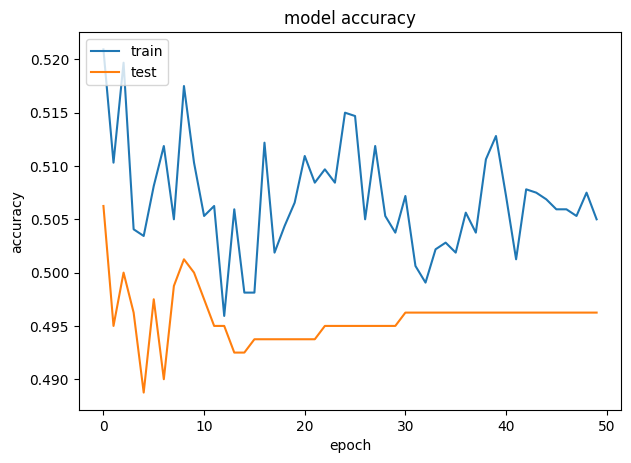

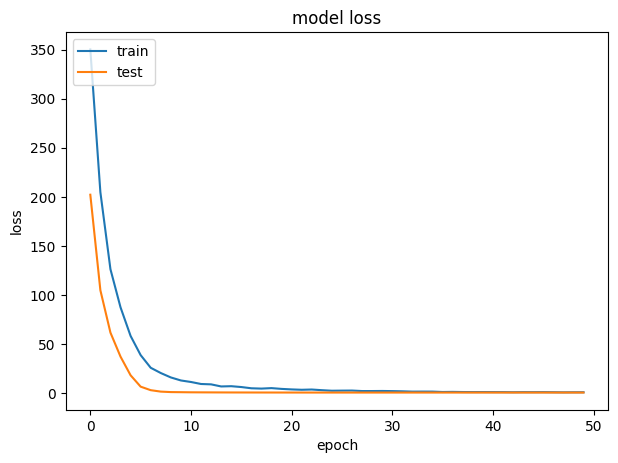

In [27]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Modelo simples com Redes Neurais  (Early Stopping)

Epoch 1/30
32/32 [==============================] - 1s 10ms/step - loss: 112.3061 - acc: 0.4983 - val_loss: 44.2808 - val_acc: 0.5063

Epoch 00001: val_loss improved from inf to 44.28083, saving model to best_model.h5
Epoch 2/30
32/32 [==============================] - 0s 5ms/step - loss: 29.4786 - acc: 0.5045 - val_loss: 14.3102 - val_acc: 0.5300

Epoch 00002: val_loss improved from 44.28083 to 14.31024, saving model to best_model.h5
Epoch 3/30
32/32 [==============================] - 0s 5ms/step - loss: 6.3884 - acc: 0.5058 - val_loss: 3.3185 - val_acc: 0.4888

Epoch 00003: val_loss improved from 14.31024 to 3.31849, saving model to best_model.h5
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 1.7416 - acc: 0.5015 - val_loss: 1.8804 - val_acc: 0.4837

Epoch 00004: val_loss improved from 3.31849 to 1.88039, saving model to best_model.h5
Epoch 5/30
32/32 [==============================] - 0s 5ms/step - loss: 1.1349 - acc: 0.4985 - val_loss: 1.4279 - val_acc: 0.4

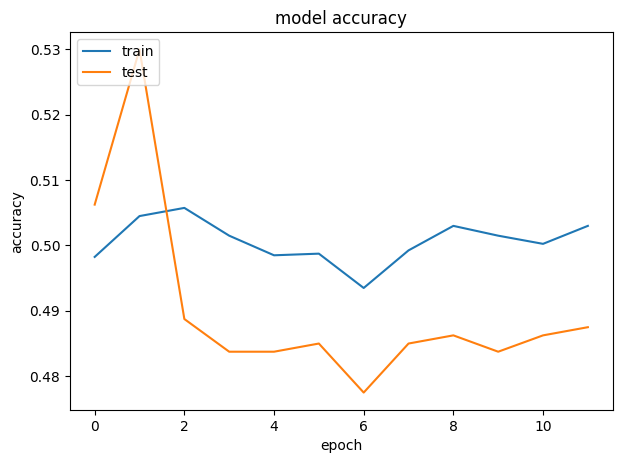

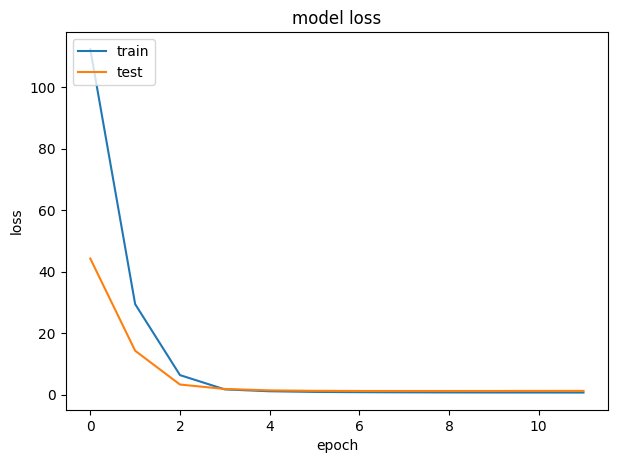

In [28]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_acc', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_val_tmp, y_val_tmp), batch_size=128, epochs=30, verbose=1, callbacks=[es, mc])
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Simple Model Embedding layer (sem Glove)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3516900   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 10001     
Total params: 3,526,901
Trainable params: 3,526,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
25/25 [==============================] - 1s 16ms/step - loss: 0.6918 - acc: 0.5234 - val_loss: 0.6865 - val_acc: 0.5562

Epoch 00001: val_loss improved from inf to 0.68650, saving model to best_model.h5
Epoch 2/20
25/25 [==============================] - 0s 9ms/step - loss: 0.6335 - acc: 0.8938 - val_loss: 0.6713 - val_acc: 0.6400

Epoch 00002: val_loss im

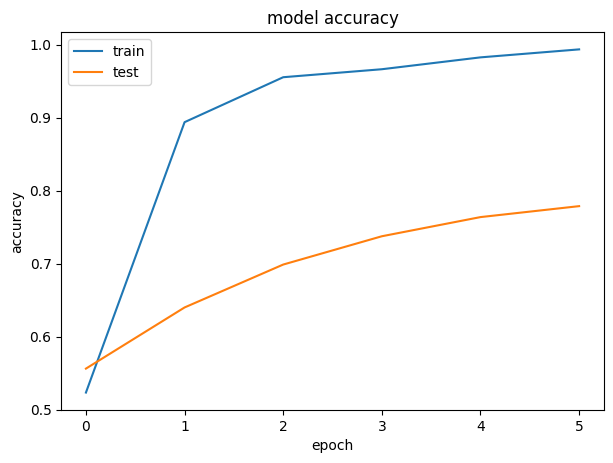

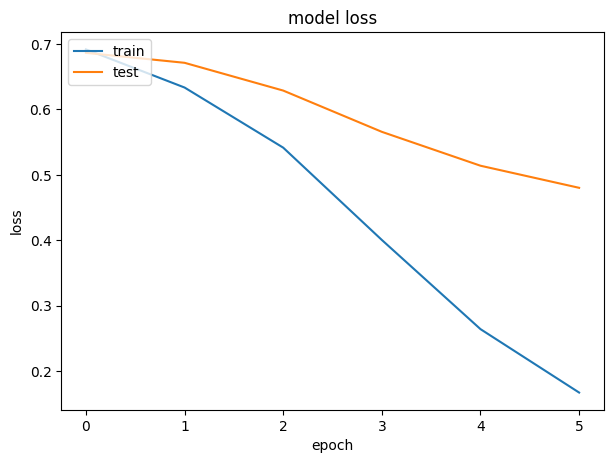

In [29]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_acc', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Glove

In [30]:
embeddings_dictionary = dict()
glove_file = open('/content/gdrive/MyDrive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Simple Model Glove (sem Early Stopping)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 10001     
Total params: 3,526,901
Trainable params: 10,001
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/20
25/25 [==============================] - 1s 10ms/step - loss: 0.7506 - acc: 0.5384 - val_loss: 0.7777 - val_acc: 0.5200
Epoch 2/20
25/25 [==============================] - 0s 4ms/step - loss: 0.5901 - acc: 0.6734 - val_loss: 0.6753 - val_acc: 0.6037
Epoch 3/20
25/25 [==============================] - 0s 4ms/step - loss: 0.4849 - acc: 0.8009 - val_loss

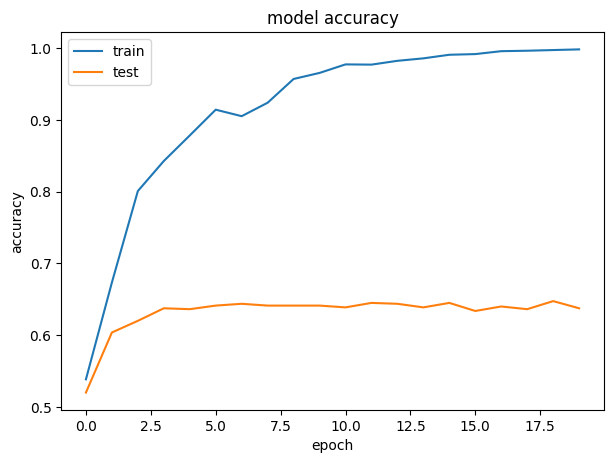

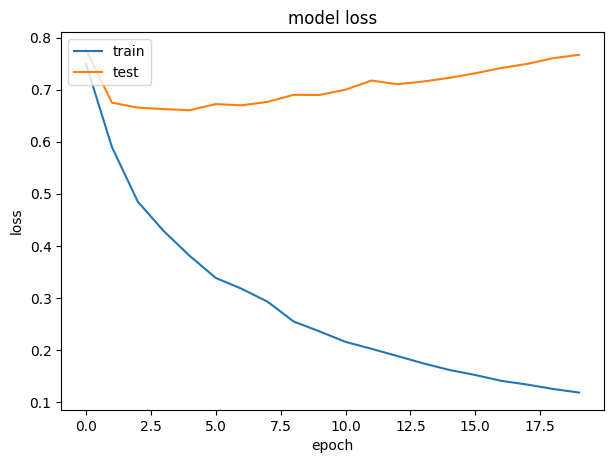

In [31]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Simple Model Glove (com Early Stopping)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 10001     
Total params: 3,526,901
Trainable params: 10,001
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/30
25/25 [==============================] - 1s 10ms/step - loss: 0.7497 - acc: 0.5484 - val_loss: 0.6946 - val_acc: 0.5675

Epoch 00001: val_loss improved from inf to 0.69455, saving model to best_model.h5
Epoch 2/30
25/25 [==============================] - 0s 4ms/step - loss: 0.5674 - acc: 0.7172 - val_loss: 0.6725 - val_acc: 0.5975

Epoch 00002: val_lo

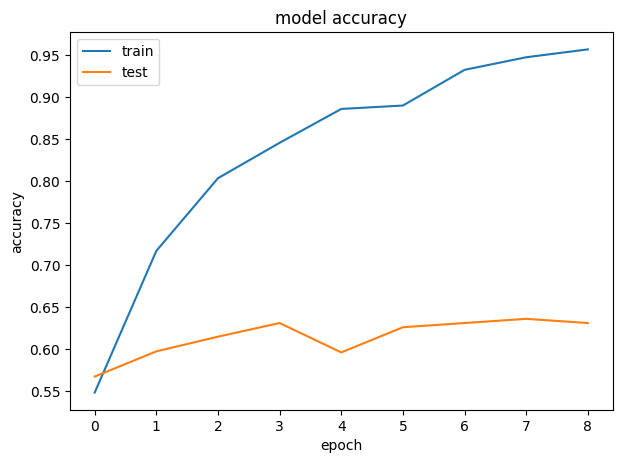

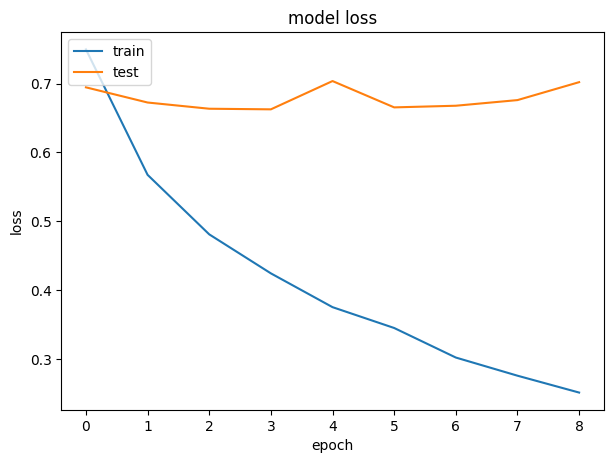

In [32]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### CNN

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 3,581,157
Trainable params: 64,257
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/50
25/25 [==============================] - 28s 21ms/step - loss: 0.6731 - acc: 0.5856 - val_loss: 0.6495 - val_acc: 0.6162
Epoch 2/50
25/25 [==============================] - 0s 9ms/step - loss: 0.5342 - acc: 0.7825 - val_l

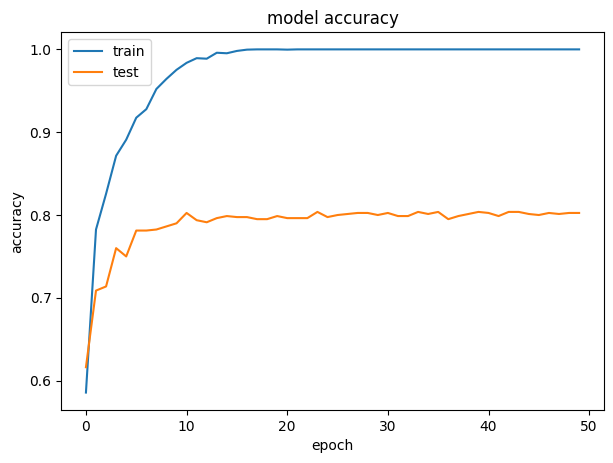

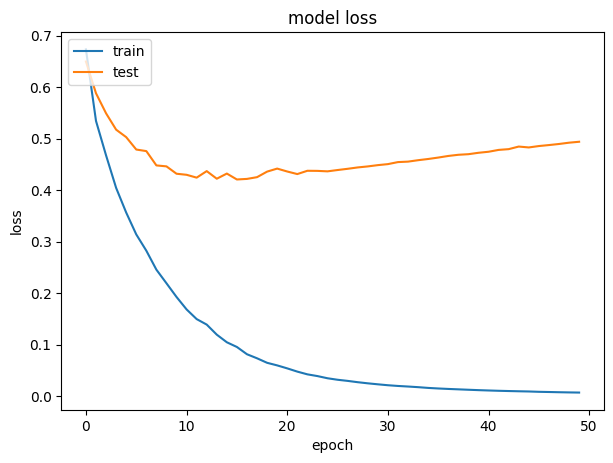

In [33]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### CNN Early Stopping

Epoch 1/30
25/25 [==============================] - 1s 19ms/step - loss: 0.6945 - acc: 0.5544 - val_loss: 0.6498 - val_acc: 0.6137

Epoch 00001: val_loss improved from inf to 0.64978, saving model to best_model.h5
Epoch 2/30
25/25 [==============================] - 0s 12ms/step - loss: 0.5479 - acc: 0.7541 - val_loss: 0.5967 - val_acc: 0.6925

Epoch 00002: val_loss improved from 0.64978 to 0.59672, saving model to best_model.h5
Epoch 3/30
25/25 [==============================] - 0s 11ms/step - loss: 0.4772 - acc: 0.8213 - val_loss: 0.5564 - val_acc: 0.7150

Epoch 00003: val_loss improved from 0.59672 to 0.55641, saving model to best_model.h5
Epoch 4/30
25/25 [==============================] - 0s 10ms/step - loss: 0.4194 - acc: 0.8600 - val_loss: 0.5329 - val_acc: 0.7412

Epoch 00004: val_loss improved from 0.55641 to 0.53294, saving model to best_model.h5
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 0.3703 - acc: 0.8869 - val_loss: 0.5001 - val_acc: 0.7538

E

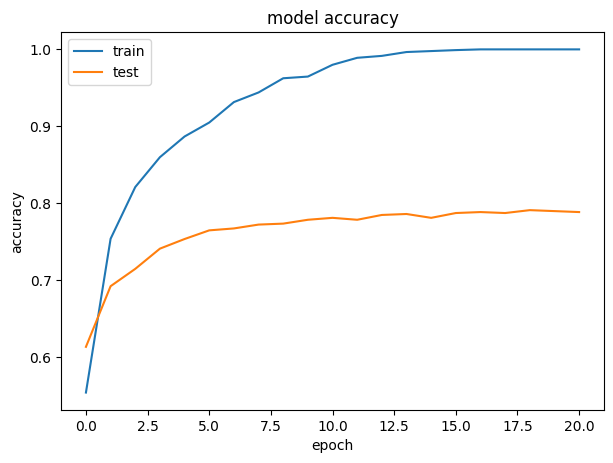

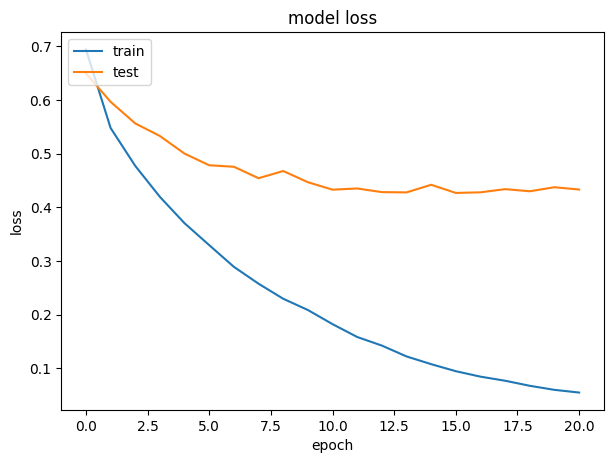

In [34]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### RNN

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               29312     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 3,546,341
Trainable params: 29,441
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/30
25/25 [==============================] - 5s 125ms/step - loss: 0.7283 - acc: 0.5206 - val_loss: 0.7001 - val_acc: 0.5225

Epoch 00001: val_loss improved from inf to 0.70010, saving model to best_model.h5
Epoch 2/30
25/25 [==============================] - 3s 116ms/step - loss: 0.6883 - acc: 0.5562 - val_loss: 0.6946 - val_acc: 0.5575

Epoch 00002: val

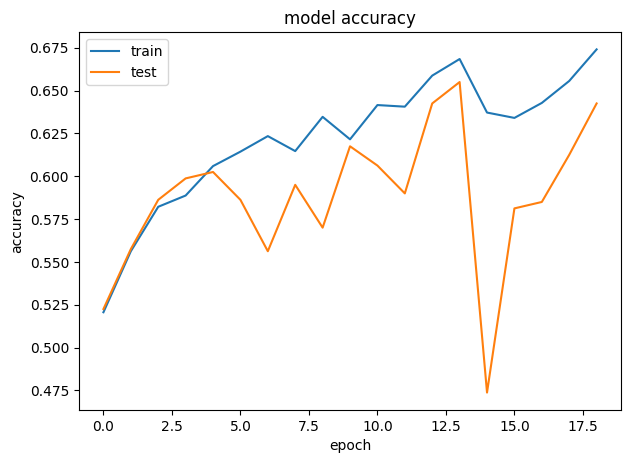

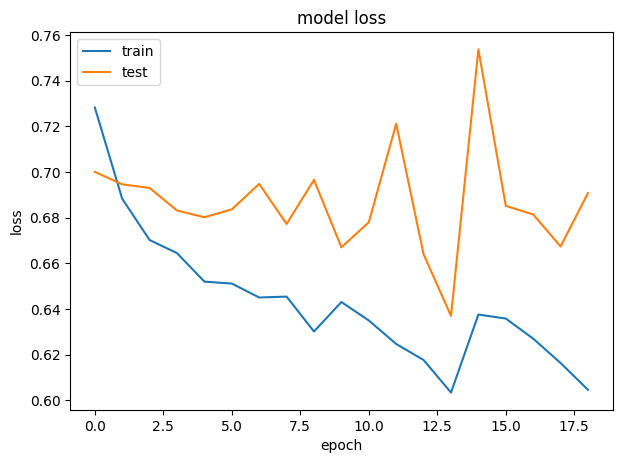

In [35]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### LSTM

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 3,634,277
Trainable params: 117,377
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/15
25/25 [==============================] - 9s 267ms/step - loss: 0.6818 - acc: 0.5544 - val_loss: 0.6741 - val_acc: 0.5875
Epoch 2/15
25/25 [==============================] - 6s 247ms/step - loss: 0.6503 - acc: 0.6322 - val_loss: 0.6483 - val_acc: 0.6237
Epoch 3/15
25/25 [==============================] - 6s 247ms/step - loss: 0.6189 - acc: 0.6631 - va

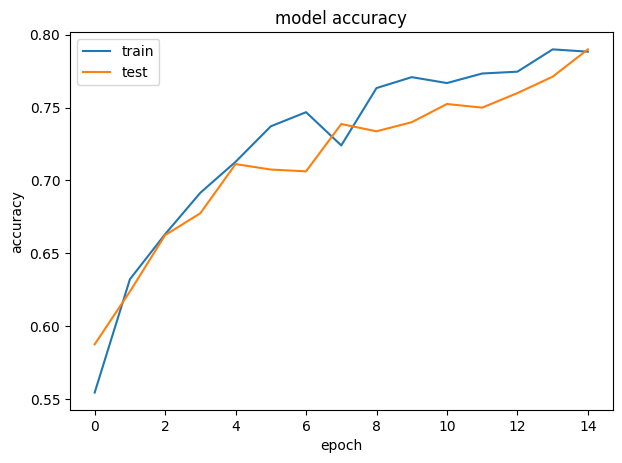

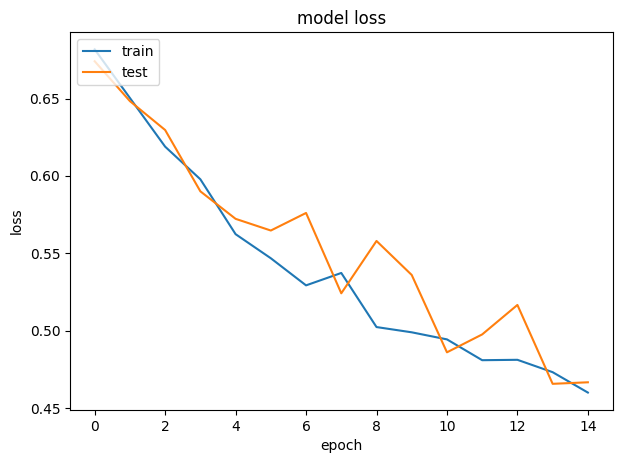

In [36]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### LSTM com Early Stopping

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 3,634,277
Trainable params: 117,377
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/100
25/25 [==============================] - 8s 256ms/step - loss: 0.6884 - acc: 0.5391 - val_loss: 0.6906 - val_acc: 0.5387

Epoch 00001: val_loss improved from inf to 0.69057, saving model to best_model.h5
Epoch 2/100
25/25 [==============================] - 6s 249ms/step - loss: 0.6656 - acc: 0.5931 - val_loss: 0.6639 - val_acc: 0.6137

Epoch 00002: 

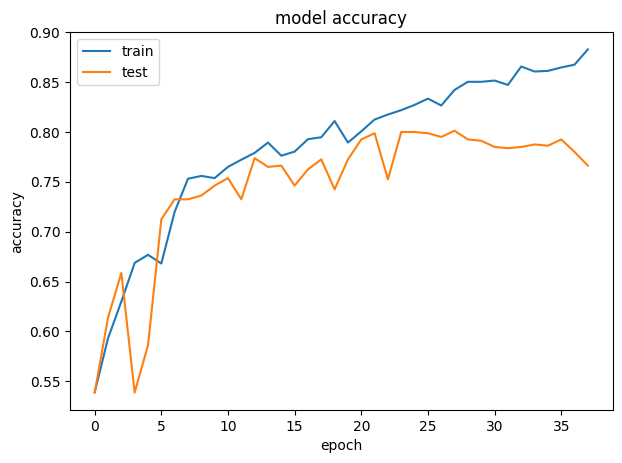

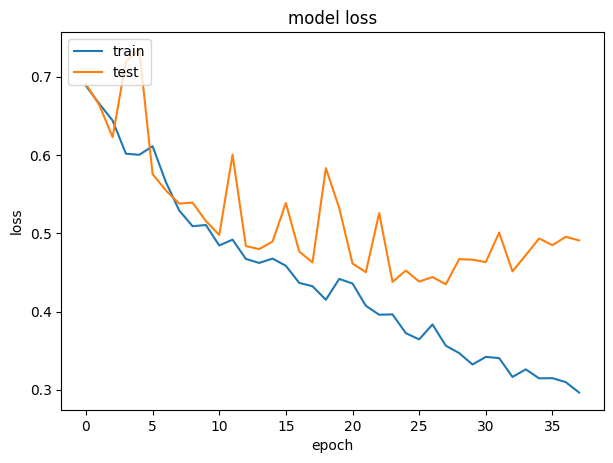

In [37]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, callbacks=[es, mc], validation_split=0.2)

# load a saved model (best model)
model = load_model('best_model.h5')
print(model.summary())

score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Prediction (sample)

In [38]:
instance = sample(X, 1)
print (instance)
instance = tokenizer.texts_to_sequences(instance)

instance = pad_sequences(instance, padding='post', maxlen=maxlen)
print (instance)

score = model.predict(instance)[0][0]
print (score)
if (score >= 0.5):
    print ('Positivo')
else:
    print ('Negativo')

['this is far worse than those awful laurel and hardy cartoons of the they were terrible but at least they were simple ripoffs of then stan and ollie resurgence new audiences had rediscovered the pair comedic genius and the cartoons were mind numbing garbage geared to cash in on children interest it was to be expected but how does one even attempt to rationalize this work of can even think of word m sure the makers hoped it would somehow inspire another laurel and hardy revival but you can inspire interest in the past with shallow and unfunny caricature of what made the original so appealing the impressionists hesitate to call them actors do vegas act and that where it belongs the plot is even flimsier than those used in the old days trying to stretch out two reel ideas for feature if this film was someone first exposure to the real laurel and hardy m sure that viewer would dismiss the original duo reputation as senility gone amok the only movie hate worse than this is spit on your gra

### Prediction (tests)

In [39]:
def score_list(list_instances):
    
    list_scores = []
    
    for text in list_instances:
        instance = tokenizer.texts_to_sequences([text])
        instance = pad_sequences(instance, padding='post', maxlen=maxlen)

        score = model.predict(instance)[0][0]
        
        if (score >= 0.5):
            flag = 'Positivo'
        else:
            flag = 'Negativo'
            
        list_scores.append([text, score, flag])
        
    df = pd.DataFrame(list_scores, columns=['text', 'score', 'rating'])
    display(df)
        
        
list_instances = ['The movie was amazing, I loved it, very good',
                  'I hate this movie, it is very bad and terrible']

# score list
score_list(list_instances)

,text,score,rating
0,"The movie was amazing, I loved it, very good",0.993837,Positivo
1,"I hate this movie, it is very bad and terrible",0.021461,Negativo


Modelo TensorFlow Hub

In [41]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load dataset info from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split ('train[:60%]', 'train[60%:]', 'test'), from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_16 (Dense)             (None, 16)                816       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 [==============================] - 5s 126ms/step - loss: 0.6694 - accuracy: 0.5249 - val_loss: 0.6196 - val_accuracy: 0.5789
Epoch 2/10
30/30 [==============================] - 4s 118ms/step - loss: 0.5560 - accuracy: 0.6675 - val_loss: 0.5180 - val_accuracy: 0.7253
Epoch 3/10
30/30 [==============================] - 5s 120ms/step - loss: 0.4282 - accu

Modelo Bert

In [42]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [43]:
dataset = tf.keras.utils.get_file(fname = 'aclImdb_v1.tar.gz',
                                  origin = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
                                  extract = True)

IMDB_DATADIR = os.path.join(os.path.dirname(dataset), 'aclImdb')

(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder(datadir = IMDB_DATADIR,
                                                                       classes = ['pos', 'neg'],
                                                                       maxlen = 200,
                                                                       train_test_names = ['train', 'test'],
                                                                       preprocess_mode = 'bert')

model = text.text_classifier(name = 'bert',
                             train_data = (x_train, y_train),
                             preproc = preproc)

learner = ktrain.get_learner(model = model,
                             train_data = (x_train, y_train),
                             val_data = (x_test, y_test),
                             batch_size = 6)

learner.fit_onecycle(lr = 2e-5,
                     epochs = 1)

detected encoding: utf-8
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 200
done.


begin training using onecycle policy with max lr of 2e-05...
4167/4167 [==============================] - 3306s 787ms/step - loss: 0.2959 - accuracy: 0.8736 - val_loss: 0.2191 - val_accuracy: 0.9107
